[nltk_data] Downloading package punkt to /Users/gavin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


DatasetDict({
    train: Dataset({
        features: ['sentence', 'relation'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['sentence', 'relation'],
        num_rows: 2717
    })
})
使用设备: mps


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 114.87it/s]


Epoch 1/20 | Train Loss: 2.0275 | Val Loss: 1.3523 | Val Acc: 0.5687 | Weighted F1: 0.5469 | Macro F1 (excl. Other): 0.4940
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.81      0.69      0.74        61
      Cause-Effect(e2,e1)       0.76      0.91      0.83       138
   Component-Whole(e1,e2)       0.63      0.72      0.67       100
   Component-Whole(e2,e1)       0.36      0.65      0.47        97
 Content-Container(e1,e2)       0.80      0.81      0.80        88
 Content-Container(e2,e1)       0.83      0.24      0.37        42
Entity-Destination(e1,e2)       0.90      0.88      0.89       158
     Entity-Origin(e1,e2)       0.88      0.64      0.74       107
     Entity-Origin(e2,e1)       1.00      0.41      0.59        29
 Instrument-Agency(e1,e2)       0.00      0.00      0.00        14
 Instrument-Agency(e2,e1)       0.51      0.42      0.46        85
 Member-Collectio

Epoch 2/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 113.08it/s]


Epoch 2/20 | Train Loss: 1.1546 | Val Loss: 1.0090 | Val Acc: 0.6700 | Weighted F1: 0.6551 | Macro F1 (excl. Other): 0.6411
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.98      0.69      0.81        61
      Cause-Effect(e2,e1)       0.95      0.83      0.89       138
   Component-Whole(e1,e2)       0.86      0.75      0.80       100
   Component-Whole(e2,e1)       0.61      0.69      0.65        97
 Content-Container(e1,e2)       0.89      0.76      0.82        88
 Content-Container(e2,e1)       0.97      0.71      0.82        42
Entity-Destination(e1,e2)       0.85      0.94      0.89       158
     Entity-Origin(e1,e2)       0.77      0.82      0.79       107
     Entity-Origin(e2,e1)       0.74      0.79      0.77        29
 Instrument-Agency(e1,e2)       0.00      0.00      0.00        14
 Instrument-Agency(e2,e1)       0.88      0.49      0.63        85
 Member-Collectio

Epoch 3/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 115.44it/s]


Epoch 3/20 | Train Loss: 0.8846 | Val Loss: 0.9541 | Val Acc: 0.6850 | Weighted F1: 0.6769 | Macro F1 (excl. Other): 0.6573
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.88      0.84      0.86        61
      Cause-Effect(e2,e1)       0.93      0.83      0.88       138
   Component-Whole(e1,e2)       0.93      0.70      0.80       100
   Component-Whole(e2,e1)       0.76      0.42      0.54        97
 Content-Container(e1,e2)       0.88      0.75      0.81        88
 Content-Container(e2,e1)       0.97      0.74      0.84        42
Entity-Destination(e1,e2)       0.84      0.94      0.89       158
     Entity-Origin(e1,e2)       0.82      0.68      0.74       107
     Entity-Origin(e2,e1)       0.95      0.72      0.82        29
 Instrument-Agency(e1,e2)       0.00      0.00      0.00        14
 Instrument-Agency(e2,e1)       0.72      0.79      0.75        85
 Member-Collectio

Epoch 4/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 114.24it/s]


Epoch 4/20 | Train Loss: 0.6872 | Val Loss: 0.8651 | Val Acc: 0.7231 | Weighted F1: 0.7243 | Macro F1 (excl. Other): 0.7271
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.87      0.90      0.89        61
      Cause-Effect(e2,e1)       0.94      0.90      0.92       138
   Component-Whole(e1,e2)       0.95      0.75      0.84       100
   Component-Whole(e2,e1)       0.84      0.53      0.65        97
 Content-Container(e1,e2)       0.81      0.90      0.85        88
 Content-Container(e2,e1)       1.00      0.62      0.76        42
Entity-Destination(e1,e2)       0.96      0.84      0.90       158
     Entity-Origin(e1,e2)       0.84      0.77      0.80       107
     Entity-Origin(e2,e1)       1.00      0.72      0.84        29
 Instrument-Agency(e1,e2)       0.60      0.21      0.32        14
 Instrument-Agency(e2,e1)       0.84      0.73      0.78        85
 Member-Collectio

Epoch 5/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 116.06it/s]


Epoch 5/20 | Train Loss: 0.5550 | Val Loss: 0.8778 | Val Acc: 0.7262 | Weighted F1: 0.7211 | Macro F1 (excl. Other): 0.7269
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.96      0.79      0.86        61
      Cause-Effect(e2,e1)       0.93      0.88      0.90       138
   Component-Whole(e1,e2)       0.89      0.77      0.82       100
   Component-Whole(e2,e1)       0.71      0.72      0.71        97
 Content-Container(e1,e2)       0.94      0.66      0.77        88
 Content-Container(e2,e1)       0.97      0.74      0.84        42
Entity-Destination(e1,e2)       0.88      0.96      0.92       158
     Entity-Origin(e1,e2)       0.89      0.79      0.84       107
     Entity-Origin(e2,e1)       1.00      0.79      0.88        29
 Instrument-Agency(e1,e2)       0.56      0.36      0.43        14
 Instrument-Agency(e2,e1)       0.87      0.71      0.78        85
 Member-Collectio

Epoch 6/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 114.72it/s]


Epoch 6/20 | Train Loss: 0.4436 | Val Loss: 0.8979 | Val Acc: 0.7331 | Weighted F1: 0.7264 | Macro F1 (excl. Other): 0.7396
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.87      0.87      0.87        61
      Cause-Effect(e2,e1)       0.93      0.90      0.91       138
   Component-Whole(e1,e2)       0.83      0.82      0.82       100
   Component-Whole(e2,e1)       0.63      0.85      0.72        97
 Content-Container(e1,e2)       0.88      0.82      0.85        88
 Content-Container(e2,e1)       0.87      0.79      0.82        42
Entity-Destination(e1,e2)       0.95      0.88      0.91       158
     Entity-Origin(e1,e2)       0.89      0.76      0.82       107
     Entity-Origin(e2,e1)       0.86      0.86      0.86        29
 Instrument-Agency(e1,e2)       0.67      0.29      0.40        14
 Instrument-Agency(e2,e1)       0.92      0.71      0.80        85
 Member-Collectio

Epoch 7/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 110.09it/s]


Epoch 7/20 | Train Loss: 0.3558 | Val Loss: 0.9427 | Val Acc: 0.7400 | Weighted F1: 0.7426 | Macro F1 (excl. Other): 0.7322
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.86      0.80      0.83        61
      Cause-Effect(e2,e1)       0.94      0.87      0.91       138
   Component-Whole(e1,e2)       0.82      0.77      0.79       100
   Component-Whole(e2,e1)       0.84      0.63      0.72        97
 Content-Container(e1,e2)       0.89      0.83      0.86        88
 Content-Container(e2,e1)       0.94      0.74      0.83        42
Entity-Destination(e1,e2)       0.90      0.90      0.90       158
     Entity-Origin(e1,e2)       0.84      0.75      0.79       107
     Entity-Origin(e2,e1)       0.86      0.83      0.84        29
 Instrument-Agency(e1,e2)       0.80      0.29      0.42        14
 Instrument-Agency(e2,e1)       0.87      0.79      0.83        85
 Member-Collectio

Epoch 8/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 113.55it/s]


Epoch 8/20 | Train Loss: 0.2006 | Val Loss: 0.9164 | Val Acc: 0.7456 | Weighted F1: 0.7481 | Macro F1 (excl. Other): 0.7493
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.88      0.80      0.84        61
      Cause-Effect(e2,e1)       0.94      0.88      0.91       138
   Component-Whole(e1,e2)       0.84      0.77      0.80       100
   Component-Whole(e2,e1)       0.74      0.74      0.74        97
 Content-Container(e1,e2)       0.89      0.74      0.81        88
 Content-Container(e2,e1)       0.94      0.71      0.81        42
Entity-Destination(e1,e2)       0.92      0.86      0.89       158
     Entity-Origin(e1,e2)       0.87      0.71      0.78       107
     Entity-Origin(e2,e1)       0.86      0.86      0.86        29
 Instrument-Agency(e1,e2)       1.00      0.29      0.44        14
 Instrument-Agency(e2,e1)       0.90      0.74      0.81        85
 Member-Collectio

Epoch 9/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 113.72it/s]


Epoch 9/20 | Train Loss: 0.1677 | Val Loss: 0.9330 | Val Acc: 0.7519 | Weighted F1: 0.7530 | Macro F1 (excl. Other): 0.7641
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.92      0.80      0.86        61
      Cause-Effect(e2,e1)       0.93      0.89      0.91       138
   Component-Whole(e1,e2)       0.84      0.78      0.81       100
   Component-Whole(e2,e1)       0.75      0.78      0.76        97
 Content-Container(e1,e2)       0.89      0.74      0.81        88
 Content-Container(e2,e1)       0.94      0.71      0.81        42
Entity-Destination(e1,e2)       0.92      0.91      0.91       158
     Entity-Origin(e1,e2)       0.88      0.74      0.80       107
     Entity-Origin(e2,e1)       0.90      0.90      0.90        29
 Instrument-Agency(e1,e2)       1.00      0.36      0.53        14
 Instrument-Agency(e2,e1)       0.88      0.74      0.80        85
 Member-Collectio

Epoch 10/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 110.71it/s]


Epoch 10/20 | Train Loss: 0.1422 | Val Loss: 0.9663 | Val Acc: 0.7481 | Weighted F1: 0.7490 | Macro F1 (excl. Other): 0.7590
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.91      0.79      0.84        61
      Cause-Effect(e2,e1)       0.92      0.89      0.91       138
   Component-Whole(e1,e2)       0.82      0.78      0.80       100
   Component-Whole(e2,e1)       0.74      0.75      0.74        97
 Content-Container(e1,e2)       0.92      0.74      0.82        88
 Content-Container(e2,e1)       0.94      0.71      0.81        42
Entity-Destination(e1,e2)       0.92      0.90      0.91       158
     Entity-Origin(e1,e2)       0.88      0.68      0.77       107
     Entity-Origin(e2,e1)       0.93      0.86      0.89        29
 Instrument-Agency(e1,e2)       1.00      0.29      0.44        14
 Instrument-Agency(e2,e1)       0.86      0.74      0.80        85
 Member-Collecti

Epoch 11/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 114.65it/s]


Epoch 11/20 | Train Loss: 0.1301 | Val Loss: 0.9690 | Val Acc: 0.7469 | Weighted F1: 0.7485 | Macro F1 (excl. Other): 0.7611
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.91      0.79      0.84        61
      Cause-Effect(e2,e1)       0.92      0.89      0.91       138
   Component-Whole(e1,e2)       0.82      0.77      0.79       100
   Component-Whole(e2,e1)       0.74      0.75      0.74        97
 Content-Container(e1,e2)       0.92      0.74      0.82        88
 Content-Container(e2,e1)       0.94      0.71      0.81        42
Entity-Destination(e1,e2)       0.92      0.90      0.91       158
     Entity-Origin(e1,e2)       0.89      0.69      0.78       107
     Entity-Origin(e2,e1)       0.93      0.86      0.89        29
 Instrument-Agency(e1,e2)       1.00      0.36      0.53        14
 Instrument-Agency(e2,e1)       0.86      0.74      0.80        85
 Member-Collecti

Epoch 12/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 114.32it/s]


Epoch 12/20 | Train Loss: 0.1224 | Val Loss: 0.9734 | Val Acc: 0.7456 | Weighted F1: 0.7474 | Macro F1 (excl. Other): 0.7585
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.91      0.79      0.84        61
      Cause-Effect(e2,e1)       0.92      0.89      0.91       138
   Component-Whole(e1,e2)       0.82      0.77      0.79       100
   Component-Whole(e2,e1)       0.74      0.75      0.74        97
 Content-Container(e1,e2)       0.92      0.74      0.82        88
 Content-Container(e2,e1)       0.94      0.71      0.81        42
Entity-Destination(e1,e2)       0.92      0.90      0.91       158
     Entity-Origin(e1,e2)       0.88      0.69      0.77       107
     Entity-Origin(e2,e1)       0.92      0.83      0.87        29
 Instrument-Agency(e1,e2)       1.00      0.36      0.53        14
 Instrument-Agency(e2,e1)       0.86      0.74      0.80        85
 Member-Collecti

Epoch 13/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 113.75it/s]


Epoch 13/20 | Train Loss: 0.1213 | Val Loss: 0.9793 | Val Acc: 0.7456 | Weighted F1: 0.7478 | Macro F1 (excl. Other): 0.7613
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.91      0.79      0.84        61
      Cause-Effect(e2,e1)       0.92      0.89      0.91       138
   Component-Whole(e1,e2)       0.82      0.77      0.79       100
   Component-Whole(e2,e1)       0.74      0.75      0.74        97
 Content-Container(e1,e2)       0.92      0.74      0.82        88
 Content-Container(e2,e1)       0.94      0.71      0.81        42
Entity-Destination(e1,e2)       0.92      0.90      0.91       158
     Entity-Origin(e1,e2)       0.89      0.70      0.79       107
     Entity-Origin(e2,e1)       0.92      0.83      0.87        29
 Instrument-Agency(e1,e2)       1.00      0.36      0.53        14
 Instrument-Agency(e2,e1)       0.86      0.74      0.80        85
 Member-Collecti

Epoch 14/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 112.78it/s]


Epoch 14/20 | Train Loss: 0.1220 | Val Loss: 0.9797 | Val Acc: 0.7456 | Weighted F1: 0.7478 | Macro F1 (excl. Other): 0.7613
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.91      0.79      0.84        61
      Cause-Effect(e2,e1)       0.92      0.89      0.91       138
   Component-Whole(e1,e2)       0.82      0.77      0.79       100
   Component-Whole(e2,e1)       0.74      0.75      0.74        97
 Content-Container(e1,e2)       0.92      0.74      0.82        88
 Content-Container(e2,e1)       0.94      0.71      0.81        42
Entity-Destination(e1,e2)       0.92      0.90      0.91       158
     Entity-Origin(e1,e2)       0.89      0.70      0.79       107
     Entity-Origin(e2,e1)       0.92      0.83      0.87        29
 Instrument-Agency(e1,e2)       1.00      0.36      0.53        14
 Instrument-Agency(e2,e1)       0.86      0.74      0.80        85
 Member-Collecti

Epoch 15/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 113.72it/s]


Epoch 15/20 | Train Loss: 0.1167 | Val Loss: 0.9799 | Val Acc: 0.7456 | Weighted F1: 0.7476 | Macro F1 (excl. Other): 0.7594
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.91      0.79      0.84        61
      Cause-Effect(e2,e1)       0.92      0.89      0.91       138
   Component-Whole(e1,e2)       0.82      0.77      0.79       100
   Component-Whole(e2,e1)       0.74      0.75      0.74        97
 Content-Container(e1,e2)       0.92      0.74      0.82        88
 Content-Container(e2,e1)       0.94      0.71      0.81        42
Entity-Destination(e1,e2)       0.92      0.90      0.91       158
     Entity-Origin(e1,e2)       0.89      0.70      0.79       107
     Entity-Origin(e2,e1)       0.92      0.83      0.87        29
 Instrument-Agency(e1,e2)       1.00      0.36      0.53        14
 Instrument-Agency(e2,e1)       0.86      0.74      0.80        85
 Member-Collecti

Epoch 16/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 113.74it/s]


Epoch 16/20 | Train Loss: 0.1153 | Val Loss: 0.9809 | Val Acc: 0.7456 | Weighted F1: 0.7477 | Macro F1 (excl. Other): 0.7609
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.91      0.79      0.84        61
      Cause-Effect(e2,e1)       0.92      0.89      0.91       138
   Component-Whole(e1,e2)       0.82      0.77      0.79       100
   Component-Whole(e2,e1)       0.74      0.75      0.74        97
 Content-Container(e1,e2)       0.92      0.74      0.82        88
 Content-Container(e2,e1)       0.94      0.71      0.81        42
Entity-Destination(e1,e2)       0.92      0.90      0.91       158
     Entity-Origin(e1,e2)       0.89      0.70      0.79       107
     Entity-Origin(e2,e1)       0.92      0.83      0.87        29
 Instrument-Agency(e1,e2)       1.00      0.36      0.53        14
 Instrument-Agency(e2,e1)       0.86      0.74      0.80        85
 Member-Collecti

Epoch 17/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 112.97it/s]


Epoch 17/20 | Train Loss: 0.1148 | Val Loss: 0.9810 | Val Acc: 0.7456 | Weighted F1: 0.7477 | Macro F1 (excl. Other): 0.7609
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.91      0.79      0.84        61
      Cause-Effect(e2,e1)       0.92      0.89      0.91       138
   Component-Whole(e1,e2)       0.82      0.77      0.79       100
   Component-Whole(e2,e1)       0.74      0.75      0.74        97
 Content-Container(e1,e2)       0.92      0.74      0.82        88
 Content-Container(e2,e1)       0.94      0.71      0.81        42
Entity-Destination(e1,e2)       0.92      0.90      0.91       158
     Entity-Origin(e1,e2)       0.89      0.70      0.79       107
     Entity-Origin(e2,e1)       0.92      0.83      0.87        29
 Instrument-Agency(e1,e2)       1.00      0.36      0.53        14
 Instrument-Agency(e2,e1)       0.86      0.74      0.80        85
 Member-Collecti

Epoch 18/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 113.94it/s]


Epoch 18/20 | Train Loss: 0.1170 | Val Loss: 0.9810 | Val Acc: 0.7456 | Weighted F1: 0.7477 | Macro F1 (excl. Other): 0.7609
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.91      0.79      0.84        61
      Cause-Effect(e2,e1)       0.92      0.89      0.91       138
   Component-Whole(e1,e2)       0.82      0.77      0.79       100
   Component-Whole(e2,e1)       0.74      0.75      0.74        97
 Content-Container(e1,e2)       0.92      0.74      0.82        88
 Content-Container(e2,e1)       0.94      0.71      0.81        42
Entity-Destination(e1,e2)       0.92      0.90      0.91       158
     Entity-Origin(e1,e2)       0.89      0.70      0.79       107
     Entity-Origin(e2,e1)       0.92      0.83      0.87        29
 Instrument-Agency(e1,e2)       1.00      0.36      0.53        14
 Instrument-Agency(e2,e1)       0.86      0.74      0.80        85
 Member-Collecti

Epoch 19/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 113.75it/s]


Epoch 19/20 | Train Loss: 0.1151 | Val Loss: 0.9811 | Val Acc: 0.7456 | Weighted F1: 0.7477 | Macro F1 (excl. Other): 0.7609
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.91      0.79      0.84        61
      Cause-Effect(e2,e1)       0.92      0.89      0.91       138
   Component-Whole(e1,e2)       0.82      0.77      0.79       100
   Component-Whole(e2,e1)       0.74      0.75      0.74        97
 Content-Container(e1,e2)       0.92      0.74      0.82        88
 Content-Container(e2,e1)       0.94      0.71      0.81        42
Entity-Destination(e1,e2)       0.92      0.90      0.91       158
     Entity-Origin(e1,e2)       0.89      0.70      0.79       107
     Entity-Origin(e2,e1)       0.92      0.83      0.87        29
 Instrument-Agency(e1,e2)       1.00      0.36      0.53        14
 Instrument-Agency(e2,e1)       0.86      0.74      0.80        85
 Member-Collecti

Epoch 20/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 112.38it/s]


Epoch 20/20 | Train Loss: 0.1129 | Val Loss: 0.9811 | Val Acc: 0.7456 | Weighted F1: 0.7477 | Macro F1 (excl. Other): 0.7609
Validation Classification Report (excluding 'Other'):
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.91      0.79      0.84        61
      Cause-Effect(e2,e1)       0.92      0.89      0.91       138
   Component-Whole(e1,e2)       0.82      0.77      0.79       100
   Component-Whole(e2,e1)       0.74      0.75      0.74        97
 Content-Container(e1,e2)       0.92      0.74      0.82        88
 Content-Container(e2,e1)       0.94      0.71      0.81        42
Entity-Destination(e1,e2)       0.92      0.90      0.91       158
     Entity-Origin(e1,e2)       0.89      0.70      0.79       107
     Entity-Origin(e2,e1)       0.92      0.83      0.87        29
 Instrument-Agency(e1,e2)       1.00      0.36      0.53        14
 Instrument-Agency(e2,e1)       0.86      0.74      0.80        85
 Member-Collecti

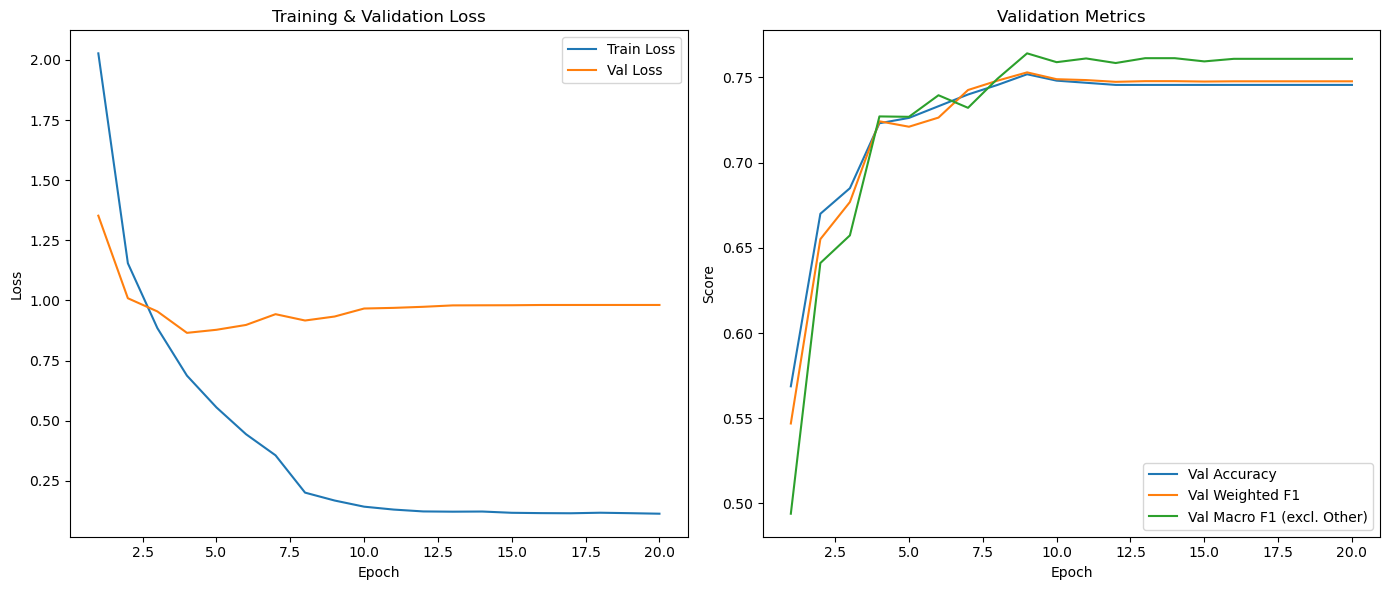

In [33]:
# 安装必要库
!pip install datasets matplotlib seaborn

# 导入库
from datasets import load_dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tqdm import tqdm
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import copy

nltk.download('punkt')
from nltk.tokenize import word_tokenize

# 1. 加载 SemEval-2010 Task 8 数据集
dataset = load_dataset("SemEvalWorkshop/sem_eval_2010_task_8")
print(dataset)

# 2. 数据预处理
class SemEvalDataset(Dataset):
    def __init__(self, sentences, labels, word2idx, max_len=50):
        self.sentences = sentences
        self.labels = labels
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx].replace('<e1>', ' <e1> ').replace('</e1>', ' </e1> ')
        sentence = sentence.replace('<e2>', ' <e2> ').replace('</e2>', ' </e2> ')
        tokens = word_tokenize(self.sentences[idx].lower())
        seq = [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]
        if len(seq) < self.max_len:
            seq += [self.word2idx['<PAD>']] * (self.max_len - len(seq))
        else:
            seq = seq[:self.max_len]
        return torch.tensor(seq), torch.tensor(self.labels[idx])

# 3. 加载 GloVe 词向量
def load_glove_embeddings(glove_file, word2idx, embedding_dim=300):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    embeddings[word2idx['<PAD>']] = np.zeros(embedding_dim)
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word2idx:
                vector = np.asarray(values[1:], dtype='float32')
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

# 4. 基线 BiLSTM 模型（增加 Dropout）
class BiLSTMRelationExtractor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embeddings):
        super(BiLSTMRelationExtractor, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=True)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2,  
                              bidirectional=True, batch_first=True, dropout=0.3)
        # 拼接 avg_pool 和 max_pool
        self.fc = nn.Linear(hidden_dim * 4, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)  # (batch, seq_len, embedding_dim)
        lstm_out, _ = self.bilstm(x)  # (batch, seq_len, 2*hidden_dim)
        avg_pool = torch.mean(lstm_out, dim=1)
        max_pool, _ = torch.max(lstm_out, dim=1)
        out = torch.cat((avg_pool, max_pool), dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

# 5. EarlyStopping 机制（本次不使用早停止）
# 此处已移除早停止相关代码

# 关系映射表：0-17为正常关系，18为 Other
map_table = {
    0: "Cause-Effect(e1,e2)",
    1: "Cause-Effect(e2,e1)",
    2: "Component-Whole(e1,e2)",
    3: "Component-Whole(e2,e1)",
    4: "Content-Container(e1,e2)",
    5: "Content-Container(e2,e1)",
    6: "Entity-Destination(e1,e2)",
    7: "Entity-Destination(e2,e1)",
    8: "Entity-Origin(e1,e2)",
    9: "Entity-Origin(e2,e1)",
    10: "Instrument-Agency(e1,e2)",
    11: "Instrument-Agency(e2,e1)",
    12: "Member-Collection(e1,e2)",
    13: "Member-Collection(e2,e1)",
    14: "Message-Topic(e1,e2)",
    15: "Message-Topic(e2,e1)",
    16: "Product-Producer(e1,e2)",
    17: "Product-Producer(e2,e1)",
    18: "Other"
}

# 6. 主程序：训练 + 验证
if __name__ == '__main__':
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 加载数据
    sentences = dataset['train']['sentence']
    labels = dataset['train']['relation']

    # 构建词表
    all_tokens = [word_tokenize(s.lower()) for s in sentences]
    vocab = {word for tokens in all_tokens for word in tokens}
    word2idx = {word: idx + 2 for idx, word in enumerate(vocab)}
    word2idx['<PAD>'] = 0
    word2idx['<UNK>'] = 1

    # 加载 GloVe 词向量
    embedding_dim = 300
    glove_path = 'glove.6B.300d.txt'  # 确保该文件存在
    embeddings = load_glove_embeddings(glove_path, word2idx, embedding_dim)

    # 数据集与 DataLoader
    X_train, X_val, y_train, y_val = train_test_split(sentences, labels, test_size=0.2, random_state=42)
    train_dataset = SemEvalDataset(X_train, y_train, word2idx)
    val_dataset = SemEvalDataset(X_val, y_val, word2idx)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # 初始化模型
    hidden_dim = 128
    output_dim = 19  # 总共 19 类
    model = BiLSTMRelationExtractor(len(word2idx), embedding_dim, hidden_dim, output_dim, embeddings)
    model = model.to(device)

    # 损失函数 & 优化器（增加 L2 正则化）
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)

    # 用于记录训练过程
    train_losses, val_losses = [], []
    val_accuracies, val_weighted_f1_scores = [], []
    val_macro_f1_excl_other_scores = []  # 排除 Other 后的宏平均 F1

    best_macro_f1 = 0.0
    best_model_state = None

    epochs = 20
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 验证评估
        model.eval()
        y_true, y_pred = [], []
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_true.extend(y_batch.cpu().tolist())
                y_pred.extend(predicted.cpu().tolist())
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # 计算全量指标
        val_acc = accuracy_score(y_true, y_pred)
        val_weighted_f1 = f1_score(y_true, y_pred, average='weighted')
        val_accuracies.append(val_acc)
        val_weighted_f1_scores.append(val_weighted_f1)

        # 过滤掉 Other 类（标签 18），仅计算正常关系的宏平均 F1
        filtered_true, filtered_pred = [], []
        for t, p in zip(y_true, y_pred):
            if map_table[t] != "Other":
                filtered_true.append(map_table[t])
                filtered_pred.append(map_table[p])
        if len(filtered_true) > 0:
            val_macro_f1_excl_other = f1_score(filtered_true, filtered_pred, average='macro')
        else:
            val_macro_f1_excl_other = 0.0
        val_macro_f1_excl_other_scores.append(val_macro_f1_excl_other)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f} | Weighted F1: {val_weighted_f1:.4f} | "
              f"Macro F1 (excl. Other): {val_macro_f1_excl_other:.4f}")
        print("Validation Classification Report (excluding 'Other'):")
        print(classification_report(filtered_true, filtered_pred, zero_division=0))

        scheduler.step(avg_val_loss)

        # 保存验证集上 Macro F1 (排除 Other) 最高的模型
        if val_macro_f1_excl_other > best_macro_f1:
            best_macro_f1 = val_macro_f1_excl_other
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"Epoch {epoch+1}: Best Macro F1 (excl. Other) updated to {best_macro_f1:.4f}")

    # 加载最佳模型
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("加载最佳模型权重（基于验证集 Macro F1 排除 Other）。")
        torch.save(model.state_dict(), 'attention_bilstm_relation_extractor_best.pt')
        print("最佳模型已保存为 attention_bilstm_relation_extractor_best.pt")
    else:
        print("未找到更优模型，使用最后一次训练的模型。")

    # 可视化训练结果：Loss、准确率、加权 F1 和 排除 Other 的 Macro F1
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.plot(epochs_range, val_weighted_f1_scores, label='Val Weighted F1')
    plt.plot(epochs_range, val_macro_f1_excl_other_scores, label='Val Macro F1 (excl. Other)')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Metrics')
    plt.legend()
    plt.tight_layout()
    plt.show()

测试集准确率: 0.7438351122561649
测试集 Weighted F1: 0.742780595377497
测试集 Macro F1 (排除 Other): 0.7174104334841213
测试集分类报告（排除 'Other'）：
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.93      0.91      0.92       134
      Cause-Effect(e2,e1)       0.93      0.86      0.89       194
   Component-Whole(e1,e2)       0.85      0.74      0.79       162
   Component-Whole(e2,e1)       0.82      0.69      0.75       150
 Content-Container(e1,e2)       0.90      0.84      0.87       153
 Content-Container(e2,e1)       0.88      0.77      0.82        39
Entity-Destination(e1,e2)       0.93      0.87      0.90       291
Entity-Destination(e2,e1)       0.00      0.00      0.00         1
     Entity-Origin(e1,e2)       0.86      0.87      0.87       211
     Entity-Origin(e2,e1)       0.91      0.83      0.87        47
 Instrument-Agency(e1,e2)       0.61      0.50      0.55        22
 Instrument-Agency(e2,e1)       0.86      0.62      0.72       134
 

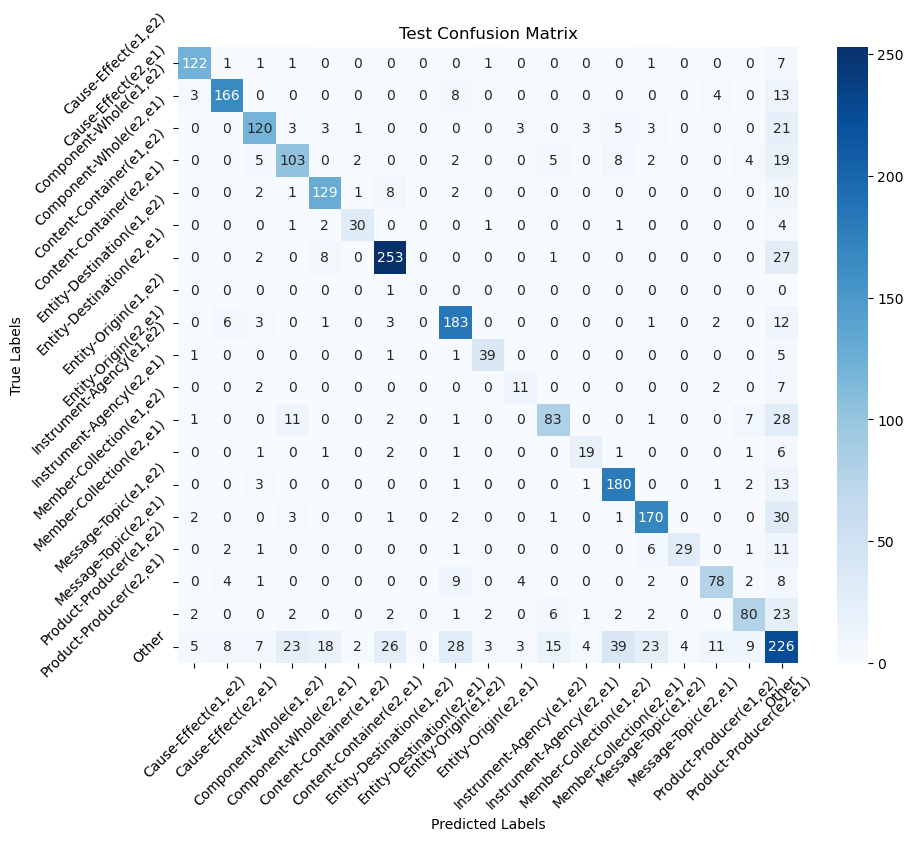

In [34]:
# -------------------------- 测试集评估代码 --------------------------

# 加载测试集数据
test_sentences = dataset['test']['sentence']
test_labels = dataset['test']['relation']
test_dataset = SemEvalDataset(test_sentences, test_labels, word2idx)
test_loader = DataLoader(test_dataset, batch_size=16)

# 评估模型在测试集上的表现
model.eval()
y_true_test, y_pred_test = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true_test.extend(y_batch.cpu().tolist())
        y_pred_test.extend(predicted.cpu().tolist())

# 计算全量指标
test_acc = accuracy_score(y_true_test, y_pred_test)
test_weighted_f1 = f1_score(y_true_test, y_pred_test, average='weighted')

# 过滤掉 "Other" 类（标签 18），仅计算正常关系的宏平均 F1
filtered_true_test, filtered_pred_test = [], []
for t, p in zip(y_true_test, y_pred_test):
    if map_table[t] != "Other":
        filtered_true_test.append(map_table[t])
        filtered_pred_test.append(map_table[p])
if len(filtered_true_test) > 0:
    test_macro_f1_excl_other = f1_score(filtered_true_test, filtered_pred_test, average='macro')
else:
    test_macro_f1_excl_other = 0.0

print("测试集准确率:", test_acc)
print("测试集 Weighted F1:", test_weighted_f1)
print("测试集 Macro F1 (排除 Other):", test_macro_f1_excl_other)

# 打印过滤后测试集的分类报告（排除 "Other"）
print("测试集分类报告（排除 'Other'）：")
print(classification_report(filtered_true_test, filtered_pred_test, zero_division=0))

# 打印完整的测试集分类报告（所有类别）
class_names = [
    "Cause-Effect(e1,e2)", "Cause-Effect(e2,e1)", "Component-Whole(e1,e2)", "Component-Whole(e2,e1)",
    "Content-Container(e1,e2)", "Content-Container(e2,e1)", "Entity-Destination(e1,e2)", "Entity-Destination(e2,e1)",
    "Entity-Origin(e1,e2)", "Entity-Origin(e2,e1)", "Instrument-Agency(e1,e2)", "Instrument-Agency(e2,e1)",
    "Member-Collection(e1,e2)", "Member-Collection(e2,e1)", "Message-Topic(e1,e2)", "Message-Topic(e2,e1)",
    "Product-Producer(e1,e2)", "Product-Producer(e2,e1)", "Other"
]

# 绘制测试集混淆矩阵（所有类别）
cm = confusion_matrix(y_true_test, y_pred_test, labels=range(len(class_names)))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Test Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

[nltk_data] Downloading package punkt to /Users/gavin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


DatasetDict({
    train: Dataset({
        features: ['sentence', 'relation'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['sentence', 'relation'],
        num_rows: 2717
    })
})
使用设备: mps


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 112.18it/s]


Epoch 1/20 | Train Loss: 2.2802 | Val Loss: 1.7203 | Val Acc: 0.5437 | Weighted F1: 0.5007 | Macro F1 (excl. Other): 0.4315
Epoch 1: Best Macro F1 (excl. Other) updated to 0.4315


Epoch 2/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 107.53it/s]


Epoch 2/20 | Train Loss: 1.5674 | Val Loss: 1.4326 | Val Acc: 0.6594 | Weighted F1: 0.6376 | Macro F1 (excl. Other): 0.6267
Epoch 2: Best Macro F1 (excl. Other) updated to 0.6267


Epoch 3/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 109.27it/s]


Epoch 3/20 | Train Loss: 1.3512 | Val Loss: 1.3529 | Val Acc: 0.6925 | Weighted F1: 0.6799 | Macro F1 (excl. Other): 0.6581
Epoch 3: Best Macro F1 (excl. Other) updated to 0.6581


Epoch 4/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 111.27it/s]


Epoch 4/20 | Train Loss: 1.2104 | Val Loss: 1.3434 | Val Acc: 0.7106 | Weighted F1: 0.7059 | Macro F1 (excl. Other): 0.7024
Epoch 4: Best Macro F1 (excl. Other) updated to 0.7024


Epoch 5/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 113.36it/s]


Epoch 5/20 | Train Loss: 1.1123 | Val Loss: 1.2778 | Val Acc: 0.7394 | Weighted F1: 0.7355 | Macro F1 (excl. Other): 0.7328
Epoch 5: Best Macro F1 (excl. Other) updated to 0.7328


Epoch 6/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 112.32it/s]


Epoch 6/20 | Train Loss: 1.0166 | Val Loss: 1.2682 | Val Acc: 0.7425 | Weighted F1: 0.7377 | Macro F1 (excl. Other): 0.7301


Epoch 7/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 109.95it/s]


Epoch 7/20 | Train Loss: 0.9463 | Val Loss: 1.2687 | Val Acc: 0.7531 | Weighted F1: 0.7518 | Macro F1 (excl. Other): 0.7460
Epoch 7: Best Macro F1 (excl. Other) updated to 0.7460


Epoch 8/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 111.29it/s]


Epoch 8/20 | Train Loss: 0.8913 | Val Loss: 1.3553 | Val Acc: 0.7219 | Weighted F1: 0.7221 | Macro F1 (excl. Other): 0.6984


Epoch 9/20: 100%|█████████████████████████████| 400/400 [00:03<00:00, 111.45it/s]


Epoch 9/20 | Train Loss: 0.8435 | Val Loss: 1.3317 | Val Acc: 0.7344 | Weighted F1: 0.7335 | Macro F1 (excl. Other): 0.7365


Epoch 10/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 109.19it/s]


Epoch 10/20 | Train Loss: 0.7672 | Val Loss: 1.2910 | Val Acc: 0.7575 | Weighted F1: 0.7576 | Macro F1 (excl. Other): 0.7592
Epoch 10: Best Macro F1 (excl. Other) updated to 0.7592


Epoch 11/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 112.34it/s]


Epoch 11/20 | Train Loss: 0.7350 | Val Loss: 1.3108 | Val Acc: 0.7569 | Weighted F1: 0.7580 | Macro F1 (excl. Other): 0.7515


Epoch 12/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 111.96it/s]


Epoch 12/20 | Train Loss: 0.7249 | Val Loss: 1.3064 | Val Acc: 0.7581 | Weighted F1: 0.7571 | Macro F1 (excl. Other): 0.7634
Epoch 12: Best Macro F1 (excl. Other) updated to 0.7634


Epoch 13/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 112.67it/s]


Epoch 13/20 | Train Loss: 0.7106 | Val Loss: 1.3116 | Val Acc: 0.7569 | Weighted F1: 0.7576 | Macro F1 (excl. Other): 0.7571


Epoch 14/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 108.60it/s]


Epoch 14/20 | Train Loss: 0.7100 | Val Loss: 1.3134 | Val Acc: 0.7538 | Weighted F1: 0.7550 | Macro F1 (excl. Other): 0.7553


Epoch 15/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 105.70it/s]


Epoch 15/20 | Train Loss: 0.7109 | Val Loss: 1.3140 | Val Acc: 0.7538 | Weighted F1: 0.7547 | Macro F1 (excl. Other): 0.7557


Epoch 16/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 107.69it/s]


Epoch 16/20 | Train Loss: 0.7073 | Val Loss: 1.3143 | Val Acc: 0.7538 | Weighted F1: 0.7548 | Macro F1 (excl. Other): 0.7559


Epoch 17/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 107.10it/s]


Epoch 17/20 | Train Loss: 0.7073 | Val Loss: 1.3145 | Val Acc: 0.7538 | Weighted F1: 0.7548 | Macro F1 (excl. Other): 0.7559


Epoch 18/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 108.08it/s]


Epoch 18/20 | Train Loss: 0.7109 | Val Loss: 1.3146 | Val Acc: 0.7531 | Weighted F1: 0.7543 | Macro F1 (excl. Other): 0.7558


Epoch 19/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 112.54it/s]


Epoch 19/20 | Train Loss: 0.7056 | Val Loss: 1.3146 | Val Acc: 0.7531 | Weighted F1: 0.7543 | Macro F1 (excl. Other): 0.7558


Epoch 20/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 112.47it/s]


Epoch 20/20 | Train Loss: 0.7086 | Val Loss: 1.3146 | Val Acc: 0.7538 | Weighted F1: 0.7549 | Macro F1 (excl. Other): 0.7561
加载最佳模型权重（基于验证集 Macro F1 排除 Other）。
最佳模型已保存为 attention_bilstm_relation_extractor_best.pt


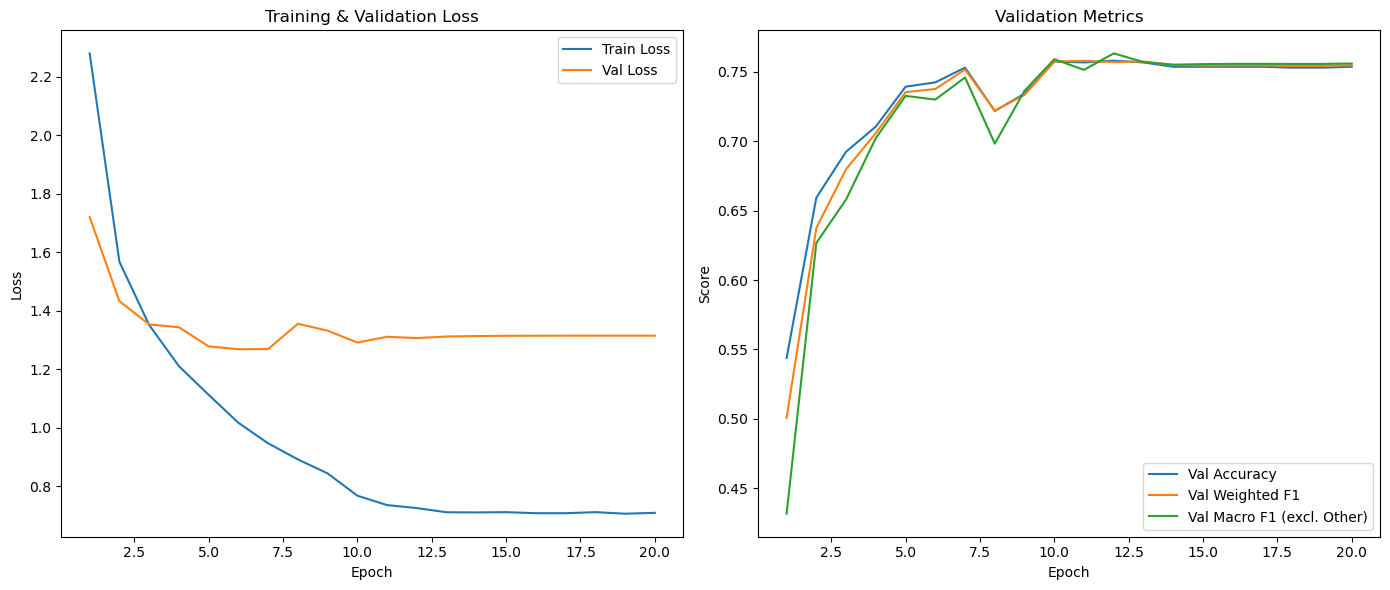

In [42]:
# 安装必要库
!pip install datasets matplotlib seaborn

# 导入库
from datasets import load_dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tqdm import tqdm
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import copy

nltk.download('punkt')
from nltk.tokenize import word_tokenize

# 1. 加载 SemEval-2010 Task 8 数据集
dataset = load_dataset("SemEvalWorkshop/sem_eval_2010_task_8")
print(dataset)

# 2. 数据预处理
class SemEvalDataset(Dataset):
    def __init__(self, sentences, labels, word2idx, max_len=50):
        self.sentences = sentences
        self.labels = labels
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx].replace('<e1>', ' <e1> ').replace('</e1>', ' </e1> ')
        sentence = sentence.replace('<e2>', ' <e2> ').replace('</e2>', ' </e2> ')
        tokens = word_tokenize(self.sentences[idx].lower())
        seq = [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]
        if len(seq) < self.max_len:
            seq += [self.word2idx['<PAD>']] * (self.max_len - len(seq))
        else:
            seq = seq[:self.max_len]
        return torch.tensor(seq), torch.tensor(self.labels[idx])

# 3. 加载 GloVe 词向量
def load_glove_embeddings(glove_file, word2idx, embedding_dim=300):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    embeddings[word2idx['<PAD>']] = np.zeros(embedding_dim)
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word2idx:
                vector = np.asarray(values[1:], dtype='float32')
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

# 4. BiLSTM 模型（增大 Dropout）
class BiLSTMRelationExtractor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embeddings):
        super(BiLSTMRelationExtractor, self).__init__()
        # 冻结或不冻结可自行选择，这里保持不变
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=True)
        # 将 LSTM dropout=0.3 改为 0.5
        self.bilstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers=2,
            bidirectional=True, batch_first=True, dropout=0.5
        )
        # 拼接 avg_pool 和 max_pool
        self.fc = nn.Linear(hidden_dim * 4, output_dim)
        # 将全连接层前的 dropout=0.5 改为 0.6
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        x = self.embedding(x)  # (batch, seq_len, embedding_dim)
        lstm_out, _ = self.bilstm(x)  # (batch, seq_len, 2*hidden_dim)
        avg_pool = torch.mean(lstm_out, dim=1)
        max_pool, _ = torch.max(lstm_out, dim=1)
        out = torch.cat((avg_pool, max_pool), dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

# 关系映射表：0-17为正常关系，18为 Other
map_table = {
    0: "Cause-Effect(e1,e2)",
    1: "Cause-Effect(e2,e1)",
    2: "Component-Whole(e1,e2)",
    3: "Component-Whole(e2,e1)",
    4: "Content-Container(e1,e2)",
    5: "Content-Container(e2,e1)",
    6: "Entity-Destination(e1,e2)",
    7: "Entity-Destination(e2,e1)",
    8: "Entity-Origin(e1,e2)",
    9: "Entity-Origin(e2,e1)",
    10: "Instrument-Agency(e1,e2)",
    11: "Instrument-Agency(e2,e1)",
    12: "Member-Collection(e1,e2)",
    13: "Member-Collection(e2,e1)",
    14: "Message-Topic(e1,e2)",
    15: "Message-Topic(e2,e1)",
    16: "Product-Producer(e1,e2)",
    17: "Product-Producer(e2,e1)",
    18: "Other"
}

# 5. 主程序：训练 + 验证（无早停止，按 Macro F1 排除 Other 保存最佳模型）
if __name__ == '__main__':
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 加载数据
    sentences = dataset['train']['sentence']
    labels = dataset['train']['relation']

    # 构建词表
    all_tokens = [word_tokenize(s.lower()) for s in sentences]
    vocab = {word for tokens in all_tokens for word in tokens}
    word2idx = {word: idx + 2 for idx, word in enumerate(vocab)}
    word2idx['<PAD>'] = 0
    word2idx['<UNK>'] = 1

    # 加载 GloVe 词向量
    embedding_dim = 300
    glove_path = 'glove.6B.300d.txt'  # 确保该文件存在
    embeddings = load_glove_embeddings(glove_path, word2idx, embedding_dim)

    # 数据集与 DataLoader
    X_train, X_val, y_train, y_val = train_test_split(sentences, labels, test_size=0.2, random_state=42)
    train_dataset = SemEvalDataset(X_train, y_train, word2idx)
    val_dataset = SemEvalDataset(X_val, y_val, word2idx)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # 初始化模型
    hidden_dim = 128
    output_dim = 19  # 总共 19 类
    model = BiLSTMRelationExtractor(len(word2idx), embedding_dim, hidden_dim, output_dim, embeddings)
    model.to(device)

    # 1) 使用 Label Smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    # 2) 使用 L2 正则化
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    # 学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)

    # 用于记录训练过程
    train_losses, val_losses = [], []
    val_accuracies, val_weighted_f1_scores = [], []
    val_macro_f1_excl_other_scores = []  # 排除 Other 后的宏平均 F1

    best_macro_f1 = 0.0
    best_model_state = None

    epochs = 20
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 验证评估
        model.eval()
        y_true, y_pred = [], []
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_true.extend(y_batch.cpu().tolist())
                y_pred.extend(predicted.cpu().tolist())
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # 计算全量指标
        val_acc = accuracy_score(y_true, y_pred)
        val_weighted_f1 = f1_score(y_true, y_pred, average='weighted')
        val_accuracies.append(val_acc)
        val_weighted_f1_scores.append(val_weighted_f1)

        # 过滤掉 Other 类（标签 18），仅计算正常关系的宏平均 F1
        filtered_true, filtered_pred = [], []
        for t, p in zip(y_true, y_pred):
            if map_table[t] != "Other":
                filtered_true.append(map_table[t])
                filtered_pred.append(map_table[p])
        if len(filtered_true) > 0:
            val_macro_f1_excl_other = f1_score(filtered_true, filtered_pred, average='macro')
        else:
            val_macro_f1_excl_other = 0.0
        val_macro_f1_excl_other_scores.append(val_macro_f1_excl_other)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f} | Weighted F1: {val_weighted_f1:.4f} | "
              f"Macro F1 (excl. Other): {val_macro_f1_excl_other:.4f}")

        # 学习率调度
        scheduler.step(avg_val_loss)

        # 保存验证集上 Macro F1 (排除 Other) 最高的模型
        if val_macro_f1_excl_other > best_macro_f1:
            best_macro_f1 = val_macro_f1_excl_other
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"Epoch {epoch+1}: Best Macro F1 (excl. Other) updated to {best_macro_f1:.4f}")

    # 训练结束后加载最佳模型
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("加载最佳模型权重（基于验证集 Macro F1 排除 Other）。")
        torch.save(model.state_dict(), 'attention_bilstm_relation_extractor_best.pt')
        print("最佳模型已保存为 attention_bilstm_relation_extractor_best.pt")
    else:
        print("没有找到更优模型，使用最后一次训练的模型权重。")

    # 可视化训练结果
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 6))

    # (1) Loss 曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # (2) Accuracy / Weighted F1 / Macro F1(excl.Other)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.plot(epochs_range, val_weighted_f1_scores, label='Val Weighted F1')
    plt.plot(epochs_range, val_macro_f1_excl_other_scores, label='Val Macro F1 (excl. Other)')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Metrics')
    plt.legend()

    plt.tight_layout()
    plt.show()

测试集准确率: 0.7350018402649982
测试集 Macro F1 (排除 Other): 0.7570413543650081


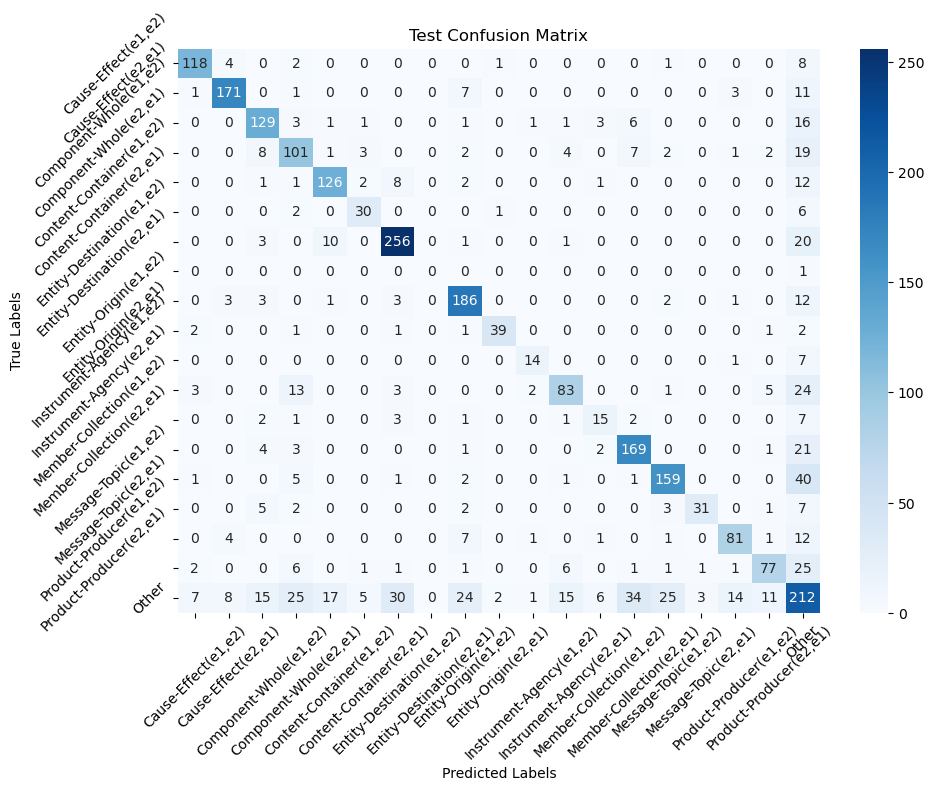

In [50]:
# -------------------------- 测试集评估代码 (修改后) --------------------------
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 手动计算准确率
def compute_accuracy(y_true, y_pred):
    correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
    return correct / len(y_true) if len(y_true) > 0 else 0.0

# 2) 手动计算去除 Other 后(假设 Other=18)的宏平均F1，并只除以18
def compute_macro_f1_excl_other(y_true, y_pred, other_label=18):
    """
    - y_true, y_pred: list or array of integer labels (0..17 => 18类关系, 18 => Other)
    - other_label: which label is considered 'Other'. Default=18
    - returns: Macro-F1 over 0..17, ignoring real-labeled-other samples
    """
    # 1) 过滤掉真实标签=other_label(18)的样本
    #    这样只关注 '真实是 0..17' 的样本
    filtered_pairs = [(t, p) for t, p in zip(y_true, y_pred) if t != other_label]
    if len(filtered_pairs) == 0:
        return 0.0
    
    # 2) 因为预测p可能是18, 所以数组至少要开到 19
    #    这样不会访问越界
    K = other_label + 1  # =19
    tp = np.zeros(K, dtype=np.float32)
    fp = np.zeros(K, dtype=np.float32)
    fn = np.zeros(K, dtype=np.float32)

    for t, p in filtered_pairs:
        if t == p:
            tp[t] += 1
        else:
            fp[p] += 1
            fn[t] += 1

    # 3) 对 0..17 这18类计算 precision / recall / f1
    f1_sum = 0.0
    for i in range(other_label):  # i in [0..17]
        prec_i = tp[i] / (tp[i] + fp[i] + 1e-9)
        rec_i  = tp[i] / (tp[i] + fn[i] + 1e-9)
        if prec_i + rec_i > 0:
            f1_i = 2 * prec_i * rec_i / (prec_i + rec_i)
        else:
            f1_i = 0.0
        f1_sum += f1_i

    # 4) 最后只对 18 个关系做平均 => 除以 18
    macro_f1 = f1_sum / other_label
    return float(macro_f1)

# -------------------------- 评估过程 --------------------------
# 加载测试集数据
test_sentences = dataset['test']['sentence']
test_labels = dataset['test']['relation']  # 0..17或18=Other

test_dataset = SemEvalDataset(test_sentences, test_labels, word2idx)
test_loader = DataLoader(test_dataset, batch_size=16)

model.eval()
y_true_test, y_pred_test = [], []

# 前向推断
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)           # [B, 19] or [B, 18]? 取决于你的模型设计
        _, predicted = torch.max(outputs, dim=1)
        y_true_test.extend(y_batch.cpu().tolist())
        y_pred_test.extend(predicted.cpu().tolist())

# (A) 手动计算全量准确率
test_acc = compute_accuracy(y_true_test, y_pred_test)

# (B) 手动计算去除Other后的宏平均F1
test_macro_f1_excl_other = compute_macro_f1_excl_other(y_true_test, y_pred_test, other_label=18)

print("测试集准确率:", test_acc)
print("测试集 Macro F1 (排除 Other):", test_macro_f1_excl_other)

# (C) 绘制完整的混淆矩阵 (包含Other=18)
class_names = [
    "Cause-Effect(e1,e2)", "Cause-Effect(e2,e1)", "Component-Whole(e1,e2)", "Component-Whole(e2,e1)",
    "Content-Container(e1,e2)", "Content-Container(e2,e1)", "Entity-Destination(e1,e2)", "Entity-Destination(e2,e1)",
    "Entity-Origin(e1,e2)", "Entity-Origin(e2,e1)", "Instrument-Agency(e1,e2)", "Instrument-Agency(e2,e1)",
    "Member-Collection(e1,e2)", "Member-Collection(e2,e1)", "Message-Topic(e1,e2)", "Message-Topic(e2,e1)",
    "Product-Producer(e1,e2)", "Product-Producer(e2,e1)", "Other"
]

cm = confusion_matrix(y_true_test, y_pred_test, labels=range(len(class_names)))

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Test Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
!pip install deep_translator
import random
import re
from deep_translator import GoogleTranslator
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

# ---------------- Step 1: 定义增强方法 ----------------
def extract_entities(sentence):
    """ 提取 <e1> 和 <e2> 之间的实体 """
    e1_match = re.search(r"<e1>(.*?)</e1>", sentence)
    e2_match = re.search(r"<e2>(.*?)</e2>", sentence)

    e1 = e1_match.group(1) if e1_match else None
    e2 = e2_match.group(1) if e2_match else None
    return e1, e2

def get_synonym(word, pos):
    """ 获取单词的同义词（确保词性匹配） """
    pos_mapping = {
        'NN': wordnet.NOUN,   # 名词
        'VB': wordnet.VERB,   # 动词
        'JJ': wordnet.ADJ,    # 形容词
        'RB': wordnet.ADV     # 副词
    }
    wn_pos = pos_mapping.get(pos[:2], None)  # 只取前两个字母，如 'VBZ' -> 'VB'

    if wn_pos:
        synonyms = wordnet.synsets(word, pos=wn_pos)
    else:
        synonyms = wordnet.synsets(word)

    synonym_list = [syn.lemmas()[0].name() for syn in synonyms if syn.lemmas()]
    if synonym_list:
        new_word = random.choice(synonym_list)
        return new_word if new_word.lower() != word.lower() else word
    return word  # 无同义词时返回原词

def synonym_replace_sentence(sentence):
    """ 
    - **随机替换 `<e1>` 和 `<e2>` 内的实体**
    - **随机替换 `<e1>` 和 `<e2>` 之间的单词**
    - **使用 POS 词性匹配，确保句子结构正确**
    """
    e1, e2 = extract_entities(sentence)
    if not e1 or not e2:
        return sentence  # 确保实体不为空

    # 替换 `<e1>` 和 `<e2>` 里的实体
    new_e1 = get_synonym(e1, "NN")  # 假设实体通常是名词
    new_e2 = get_synonym(e2, "NN")

    new_sentence = sentence.replace(f"<e1>{e1}</e1>", f"<e1>{new_e1}</e1>")
    new_sentence = new_sentence.replace(f"<e2>{e2}</e2>", f"<e2>{new_e2}</e2>")

    # **使用正则表达式分词，确保 `<e1>` 和 `<e2>` 不会被拆分**
    words = re.findall(r"(<e1>|</e1>|<e2>|</e2>|[\w']+|[.,!?;])", new_sentence)
    words_pos = pos_tag(words)  # 获取词性标注

    # 找到 `<e1>` 和 `<e2>` 的位置
    start_e1 = words.index("<e1>") + 2  # `<e1>` + 实体
    end_e1 = words.index("</e1>")
    start_e2 = words.index("<e2>") + 2
    end_e2 = words.index("</e2>")

    # **选择 `<e1>` 和 `<e2>` 之间 50% 的单词进行随机替换**
    words_to_replace = [i for i in range(end_e1 + 1, start_e2 - 1) if words[i].isalpha()]
    random.shuffle(words_to_replace)  # 打乱顺序
    num_replace = max(1, len(words_to_replace) // 2)  # 50% 进行替换

    for i in words_to_replace[:num_replace]:  
        word, pos = words_pos[i]
        words[i] = get_synonym(word, pos)

    # **重新组合句子**
    new_sentence = " ".join(words)
    return new_sentence

def back_translate_google(sentence):
    """
    使用 Google Translate API 进行多语言回译，确保 `<e1>` 和 `<e2>` 结构不变
    """
    e1, e2 = extract_entities(sentence)
    if not e1 or not e2:
        return sentence  # 确保实体不为空

    # **保护 `<e1>` 和 `<e2>` 结构**
    sentence_no_tags = sentence.replace(f"<e1>{e1}</e1>", "E1_PLACEHOLDER")
    sentence_no_tags = sentence_no_tags.replace(f"<e2>{e2}</e2>", "E2_PLACEHOLDER")

    # **设定可选的回译语言**
    languages = ["fr", "es", "de", "zh-CN", "ru", "it", "nl"]  # 法语, 西班牙语, 德语, 中文, 俄语, 意大利语, 荷兰语
    tgt_lang = random.choice(languages)

    # **先翻译成目标语言**
    translated = GoogleTranslator(source="en", target=tgt_lang).translate(sentence_no_tags)
    # **再翻译回英文**
    back_translated = GoogleTranslator(source=tgt_lang, target="en").translate(translated)

    # **确保 `E1_PLACEHOLDER` 和 `E2_PLACEHOLDER` 被正确替换**
    placeholders = ["E1_PLACEHOLDER", "e1_placeholder", "E1_PlaceHolder"]  # 可能的大小写变化
    for ph in placeholders:
        back_translated = re.sub(ph, f"<e1>{e1}</e1>", back_translated)

    placeholders = ["E2_PLACEHOLDER", "e2_placeholder", "E2_PlaceHolder"]
    for ph in placeholders:
        back_translated = re.sub(ph, f"<e2>{e2}</e2>", back_translated)

    return back_translated


# ---------------- Step 2: 数据增强 ----------------
# **示例训练数据（类别 7）**
train_sentences = ["<e1>People</e1> have been moving back into <e2>downtown</e2>."]
train_labels = [7]

# **进行同义词替换**
augmented_sentences = []
for _ in range(5):  # 先生成 5 组同义词增强
    new_sentence = synonym_replace_sentence(train_sentences[0])
    augmented_sentences.append(new_sentence)

# **然后进行多种语言回译**
for _ in range(5):  # 再生成 5 组回译增强
    new_sentence = back_translate_google(random.choice(augmented_sentences))  # 对替换后的数据进行回译
    augmented_sentences.append(new_sentence)

# ---------------- Step 3: 打印增强后的类别 7 样本 ----------------
print("\n【类别 7: 增强后的训练样本】")
for idx, s in enumerate(augmented_sentences):
    print(f"{idx + 1}. {s}")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gavin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/gavin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



【类别 7: 增强后的训练样本】
1. <e1> People </e1> have been moving back into <e2> business_district </e2> .
2. <e1> People </e1> have be moving back into <e2> business_district </e2> .
3. <e1> People </e1> have been move back into <e2> business_district </e2> .
4. <e1> People </e1> have be moving back into <e2> business_district </e2> .
5. <e1> citizenry </e1> have be move back into <e2> business_district </e2> .
6. <e1> citizenry </e1> is back in <e2> business_district </e2>.
7. <e1> citizenry </e1> returned to <e2> business_district </e2>.
8. E1_Placeholder is back at E2_Placeholder.
9. E1_Placeholder is back at E2_Placeholder.
10. E1_Placeholder returns to E2_Placeholder.
